# MECHANISMS OF ACTION 
The goal of the model is to increase the throughput of identifying mechanisms of actions for drugs (MoA). An MoA helps doctors and researchers determine potential factors they might need to monitor for a patient when taking certain medication, identifying which drug works better at targeting specific aspects of a disease, and speed up the production of agnostics. 

To identify a mechanism of action for a drug, we need to first understand how a drug works. Most drugs are molecules which bind to specific receptors or proteins on a pathogen's surface. This can be the LPS on a bacteria cell wall for example or the Angiotensin-converting enzyme 2 (ACE2) receptor on COVID-19 which allows it to directly infect other cells. The drugs have a certain affinity to the receptor, and vice versa whether that is the chemical linkage that allows the medication to have an effect or the actual molecule and action. Antibiotics are a great example of this as they are simply molecules which attach to specific bacterial species' resistance mechanisms such as efflux pumps. 

However, finding effective molecules with desirable traits can be hard especially when it comes to making mass-market products. In fact, the hinderence of discovery is making antibiotics unprofitable as bacteria are becoming increasinly resistant to traditional antibiotics while it becomes more difficult to discover antibiotics that have different MoAs to combat that resistance. 

In framing this problem, we have a few objectives. [1] We want to be able to identify the MoA of a drug [2] The drug MoA should match our clinical data on cell viability and gene motifs [3] We want to find the most versatile drug that can target several mechanisms of actions

The first step to all of this becomes being able to quickly predict a drug's MoA based on the data we've collected from patients [2]. Fundamentally, this is a multi-label classification problem where we need to accurately predict what MoAs are at play for a given sample.

## 1. Learn and Explore the Data

In [1]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

%matplotlib inline

train_features = pd.read_csv('train_features.csv') #train data
test_features = pd.read_csv('test_features.csv') #test data
train_targets_n = pd.read_csv('train_targets_nonscored.csv') #train label template
train_targets = pd.read_csv('train_targets_scored.csv') #train label with values (has a lot of variance)

def show_df(df, n=4):
    display(df.head(n=n))

show_df(train_features)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154


### Let's try to first understand what the data is showing and find patterns in all of the features we have

This data is adapted from the L1000 dataset, one of th ebiggest collections of landmark gene expression profiles tested based on different medical doses and administration types. We can refer to the dataset glossary and connectome project website https://clue.io/connectopedia/glossary for more information. 

The first thing we need to understand is what is the importance of the genes and the data itself. The gene expressions marked here are from landmark genes [https://clue.io/connectopedia/what_are_landmark_genes] which are genes which represent a greater population profile. We have tens of thousands of genes in our body and so mapping all of that data would not only be unrealistic, but also inefficient. Think of landmark genes as a final version of PCA where the dimensionality of the data can be reduced by just characterizing a particular set of genes as 1 landmark gene whose attributes are the mean of the set. This is accurate primarily because of the group's findings on how certain genes are very correlated to each other.

The values measured are the z-scores of a gene's expression. This value is derived from Differential Gene Expression (DGE) the difference between a gene’s expression in the presence of a pertubagen or treatment and the expression of the gene when the pertubagen is not present. 

Z-score = E(p=0) - E(p=1) --> note that E() can be defined as the expression value/no. of genes expressed function or differential, p as the total presence of the pertubagen (0 represents the abundance of the gene with no pertubagen, 1 is the total presence of the gene when the pertubagen was introduced into the system). 

This also may help provide intution for the scale because negatives indicate that the total number of genes that were expressed decreased as a result of the pertubagen. The reason the values are negative or positive is because the Z-score you see is the log of the change in gene expression. The log result is negative if the gene expression crosses the inflexion point where the change is negative in nature. 

In [2]:
print(train_features.cp_type.value_counts())

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64


### Checking out the data, we can see that it is already normalized for the 879 features 
We can one-hot encode all of the classes with different values using dummies and drop the column

In [30]:
class_columns = pd.get_dummies(train_features[['cp_type', 'cp_time', 'cp_dose']].astype(str))
train_features = pd.concat([train_features, class_columns], axis=1).drop(['cp_type', 'cp_time', 'cp_dose'], axis=1)

print("Train Features")
show_df(train_features)

print("Train Targets Scored")
show_df(train_targets)

Train Features


,sig_id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-97,c-98,c-99,cp_type_ctl_vehicle,cp_type_trt_cp,cp_time_24,cp_time_48,cp_time_72,cp_dose_D1,cp_dose_D2
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,...,0.2139,0.3801,0.4176,0,1,1,0,0,1,0
1,id_000779bfc,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,...,0.1241,0.6077,0.7371,0,1,0,0,1,1,0
2,id_000a6266a,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,...,-0.2187,-1.4080,0.6931,0,1,0,1,0,1,0
3,id_0015fd391,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,...,-0.8784,-0.3876,-0.8154,0,1,0,1,0,1,0


Train Targets Scored


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### For ease of usage, we shoulve remove the drug id and use the list indices for initial reference as both the labels and training data are in the same corresponding order
After this code block, we can take a look at the frequency of the labels (columns) across the data points. Simply put, we're looking at how many rows have the corresponding label a part of their merchanism of action. This is critical in identifying either outliers or noise in the data that adds no value. 

--------

In [4]:
from sklearn import preprocessing

all_features = dict(train_targets.sum()[1:].sort_values())
train_X_var = train_features.columns.tolist()
train_X, train_y = train_features.values.tolist(), train_targets.values.tolist()

pca_id = [train_X[i][0] for i in range(0, len(train_X))]

for idx, item in enumerate(train_X):
    train_X[idx].pop(0)
    train_y[idx].pop(0)
    
pca_vars = train_X_var[1:-7]
pca_data = [train_X[i][:-7] for i in range(0, len(train_X))]

print(len(pca_data[1]))
print(len(pca_vars))
print(len(pca_id))
# print(pca_id)

868
868
23814


In [61]:
pca_df = pd.DataFrame(columns = pca_id, index=pca_vars)

for idx, column in enumerate(pca_df.columns.tolist()):
    pca_df[column] = pca_data[idx]

pca_df.head()

,id_000644bb2,id_000779bfc,id_000a6266a,id_0015fd391,id_001626bd3,id_001762a82,id_001bd861f,id_0020d0484,id_00224bf20,id_0023f063e,...,id_fff506720,id_fff6df1c5,id_fff790a17,id_fff7e6992,id_fff8c2444,id_fffb1ceed,id_fffb70c0c,id_fffc1c3f4,id_fffcb9e7c,id_ffffdd77b
g-0,1.0620,0.0743,0.6280,-0.5138,-0.3254,-0.6111,2.044,0.2711,-0.3014,-0.0630,...,-1.0140,1.7380,-0.1150,0.1420,0.1608,0.1394,-1.3260,0.3942,0.6660,-0.8598
g-1,0.5577,0.4087,0.5817,-0.2491,-0.4009,0.2941,1.700,0.5133,0.5545,0.2564,...,0.1709,-1.2900,-0.8037,-0.3696,-1.0500,-0.0636,0.3478,0.3756,0.2324,1.0240
g-2,-0.2479,0.2991,1.5540,-0.2656,0.9700,-0.9901,-1.539,-0.1327,-0.2576,-0.5279,...,-0.4291,-0.4533,0.0988,-0.0093,0.2551,-0.1112,-0.3743,0.3109,0.4392,-0.1361
g-3,-0.6208,0.0604,-0.0764,0.5288,0.6919,0.2277,5.944,2.5950,-0.1390,-0.2541,...,1.8750,-1.1640,-0.1301,-0.2495,-0.2239,-0.5080,0.9905,-0.7389,0.2044,0.7952
g-4,-0.1944,1.0190,-0.0323,4.0620,1.4180,1.2810,-2.167,0.6980,-0.6487,-0.0182,...,0.9859,-0.4841,0.2013,-0.0175,-0.2431,-0.4713,-0.7178,0.5505,0.8531,-0.3611


The results clearly indicate an off distribution in the dataset. While the majority of labels fall under a similar range, the minimum and maximum values deviate from the norm. 

In [5]:
keys = all_features.keys()
values = all_features.values()

plt.figure(figsize=(200, 200))
plt.bar(keys, values)
plt.show()


Before analyzing this data and trend furthermore, I'm going to first convert all of the values to tensors for passing the data through my models. 

In [32]:
for idx, item in enumerate(train_X):
    train_X[idx] = torch.tensor(train_X[idx])
    train_y[idx] = torch.tensor(train_y[idx])
    
print(train_X[0].shape, train_y[0].shape)

torch.Size([879]) torch.Size([206])


In [33]:
print(all_features)

{'atp-sensitive_potassium_channel_antagonist': 1, 'erbb2_inhibitor': 1, 'diuretic': 6, 'autotaxin_inhibitor': 6, 'protein_phosphatase_inhibitor': 6, 'antiarrhythmic': 6, 'retinoid_receptor_antagonist': 6, 'nicotinic_receptor_agonist': 6, 'atm_kinase_inhibitor': 6, 'calcineurin_inhibitor': 6, 'lxr_agonist': 6, 'elastase_inhibitor': 6, 'steroid': 6, 'leukotriene_inhibitor': 6, 'coagulation_factor_inhibitor': 6, 'ubiquitin_specific_protease_inhibitor': 6, 'tropomyosin_receptor_kinase_inhibitor': 6, 'laxative': 6, 'norepinephrine_reuptake_inhibitor': 7, 'bacterial_membrane_integrity_inhibitor': 7, 'aldehyde_dehydrogenase_inhibitor': 7, 'tlr_antagonist': 7, 'adenylyl_cyclase_activator': 12, 'catechol_o_methyltransferase_inhibitor': 12, 'lipase_inhibitor': 12, 'anticonvulsant': 12, 'antihistamine': 12, 'nitric_oxide_production_inhibitor': 12, 'analgesic': 12, 'ampk_activator': 12, 'atp_synthase_inhibitor': 12, 'monoacylglycerol_lipase_inhibitor': 12, 'ras_gtpase_inhibitor': 12, 'antifungal':

In [34]:
import seaborn as sns

### Based on this data, we should also continue to take out any empty data points which can hinder the quality of the model. This is a good starting point to make specific changes in your model and then evaluate their effects on the training accuracy. 

In [35]:
zero_template = list(train_y[-1])
zero_count = []

for idx, item in enumerate(train_y):
    if zero_template == list(train_y[idx]):
        zero_count.append(idx)

print(len(zero_count))
print(len(train_X))
print(len(train_y))

9367
23814
23814


In [36]:
train_y = np.delete(train_y, zero_count, axis=0)
train_X = np.delete(train_X, zero_count, axis=0)
print(len(train_X))
print(len(train_y))

14447
14447


/Users/devpatelio/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
/Users/devpatelio/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [11]:
print(train_X[14446], train_y[14446])

tensor([ 6.6600e-01,  2.3240e-01,  4.3920e-01,  2.0440e-01,  8.5310e-01,
        -3.4300e-02,  3.2300e-02,  4.6300e-02,  4.2990e-01, -7.9850e-01,
         5.7420e-01,  1.4210e-01,  2.2700e+00,  2.0460e-01,  5.3630e-01,
        -1.7330e+00,  1.4500e-01,  6.0970e-01,  2.0240e-01,  9.8650e-01,
        -7.8050e-01,  9.6080e-01,  3.4400e-01,  2.7650e+00,  4.9250e-01,
         6.6980e-01,  2.3740e-01, -3.3720e-01,  8.7710e-01, -2.6560e+00,
        -2.0000e-01, -2.0430e-01,  6.7970e-01, -2.4800e-02, -9.2700e-02,
         1.8480e+00, -2.7180e+00, -5.3160e+00, -1.0750e+00, -1.4370e-01,
        -1.7140e-01,  3.2900e-02,  8.3090e-01, -3.0180e-01,  1.5990e-01,
         1.5520e+00, -2.8000e-02,  2.7900e+00,  2.8060e+00,  8.9330e-01,
        -4.3160e+00,  4.5670e-01, -1.6260e+00,  2.7350e-01,  4.2500e-02,
         1.4880e+00, -1.8950e-01, -4.7780e-01, -6.2950e+00, -3.2500e+00,
        -1.6760e+00,  2.5700e-01,  2.5190e+00, -1.9730e+00,  7.2920e-01,
         2.7770e-01, -2.7170e+00,  1.2750e-01, -5.8

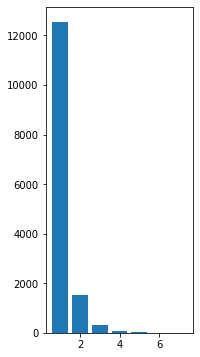

In [12]:
sum_labels = [int(sum(i)) for i in train_y]
columns = list(set(sum_labels))
values = [sum_labels.count(i) for i in columns]

plt.figure(figsize=(9, len(columns)))
plt.subplot(131)
plt.bar(columns, values)
plt.show()

In [42]:
print(values)
print(sum(values))

[12532, 1538, 303, 55, 13, 6]
14447


In [ ]:
import statsmodels.api as sm
sm.qqplot(train_X, line ='45')
py.show()

In [14]:
print(set(sum_labels))

{1, 2, 3, 4, 5, 7}


In [15]:
!pip install sklearn

In [16]:
def transform_data(X, y):
    final_return = [[torch.tensor(X[idx]), torch.tensor(y[idx])] for idx in range(len(X))]
    return final_return

dataset = transform_data(train_X, train_y)

<ipython-input-16-078b30fa41e3>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_return = [[torch.tensor(X[idx]), torch.tensor(y[idx])] for idx in range(len(X))]


### Based on the data we've collected, we should first try and train a single-label classifier for the data with just 1 class
First step would be to refactor the data into a new set of classes based no what we have already and then collect that data

In [17]:
single_label_dataset = [dataset[i] for i in range(len(dataset)) if sum(dataset[i][1]) == 1]
print(len(single_label_dataset))

12532


Before we build a classifier architecture, I'm curious to see whether there are certain apparent trends between the gene and cell viability expressions with a respective class. I'll do this in a scatterplot where the x-axis will be the gene label, the y-axis being the actual expression value, and the classes are the drug id. 

In [18]:
encoding_name_dict = {key: [] for key in train_targets.columns}
del encoding_name_dict['sig_id']
all_labels = list(encoding_name_dict.keys())

for idx, label in enumerate(all_labels):
    template = [0 for _ in range(len(all_labels))]
    template[idx] = 1
    encoding_name_dict[label] = torch.tensor(template)

# print(all_labels.index('adrenergic_receptor_antagonist'))
# print(encoding_name_dict['adrenergic_receptor_antagonist'])

testing_label = 'adrenergic_receptor_antagonist'
all_testing_label_datapoints = []

# for datapoint in single_label_dataset:
#     if list(datapoint[1]) == list(encoding_name_dict[testing_label]):
#         all_testing_label_datapoints.append()
# all_testing_label_datapoints = [x for x in single_label_dataset if x[1] == encoding_name_dict[testing_label]]

# print(single_label_dataset[199][1])
# print(encoding_name_dict[testing_label])


In [20]:
import torch.optim as optim
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class ForwardNN(nn.Module):
    def __init__ (self):
        super().__init__()
        self.fc1 = nn.Linear(879, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop = nn.Dropout(0.3)
        self.output = nn.Linear(1024, 206)

    
    def forward(self, x):
        x = x.float()
        x = F.relu_(self.drop(self.bn1(self.fc1(x))))
        x = F.relu_(self.drop(self.bn1(self.fc2(x))))
        output = F.sigmoid(self.output(x))
        
        return output


model = ForwardNN()

print(len(dataset[2381][0]), len(dataset[0][1]))
print(model)


    
def generate_k_folds(chunked_dataset):
    train_val_split = [[chunked_dataset[:x] + chunked_dataset[x+1:], chunked_dataset[x]] for x in range(len(chunked_dataset))]
    return train_val_split

def k_fold(dataset, n=10):
    break_len = int(len(list(dataset))/n)
    chunked_dataset = [dataset[x:x+break_len] for x in range(0, len(list(dataset)), break_len)]
    chunked_dataset.remove(chunked_dataset[-1])
    
    loaders = []
    copies = [chunked_dataset for _ in range(0, 10)]
    
    possible_splits = generate_k_folds(chunked_dataset)
        
    for idx_i, i in enumerate(possible_splits):
        blank_cheque = []
        for idx_x, x in enumerate(i[0]):
            blank_cheque += x
        possible_splits[idx_i][0] = blank_cheque
    
    for idx, _ in enumerate(possible_splits):
        train_loader = torch.utils.data.DataLoader(possible_splits[idx][0], shuffle=True, batch_size = 100)
        val_loader = torch.utils.data.DataLoader(possible_splits[idx][1], shuffle=False, batch_size = 100)
        loaders.append([train_loader, val_loader])
    
    return loaders, possible_splits




def train(model, data_loader):
    model.train()
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2)
    final_loss = 0
    counter = 0
    
    for data in data_loader:
        optimizer.zero_grad()
        inputs = data[0]
        targets = data[1]
        outputs = model(inputs)
#         print(type(inputs[0]), inputs.shape)
#         print(type(targets[0]), targets.shape)
        loss = loss_fn(outputs, targets.type_as(outputs))
        loss.backward()
        optimizer.step()
        final_loss += loss.item()
        counter += 1
        
    return final_loss/counter #avg loss for len_dataloader per epoch length

def validate(model, data_loader):
    model.eval()
    loss_fn = nn.BCEWithLogitsLoss()
    final_loss = 0
    
    for data in data_loader:
        inputs = data[0]
        targets = data[1]
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.type_as(outputs))
        final_loss += loss.item()
        
    return final_loss/len(data_loader)

def run_through_model(epochs, train_loader, val_loader, model):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        loss_train = train(model, train_loader)
        loss_val = validate(model, val_loader)
        train_losses.append(loss_train)
        val_losses.append(loss_val)
        print(f"Epoch: {epoch} Training loss: {loss_train}")  
#         print(f"Epoch: {epoch} Validation loss: {loss_val}")  
    
    return train_losses, val_losses
    

def for_each_loader(load_samples, epochs, model):
    avg_train_loader_losses = []
    avg_valid_loader_losses = []

    for idx, loader in enumerate(load_samples):
        trainloader, valloader = load_samples[idx][0], load_samples[idx][1]
        
        print(f'Train Loader {idx}')
        iter_train_loader_loss, iter_valid_loader_loss = run_through_model(epochs, trainloader, valloader, model)
        
        avg_valid_loader_losses.append(iter_valid_loader_loss)
        avg_train_loader_losses.append(iter_train_loader_loss)
        
        
    return avg_train_loader_losses, avg_valid_loader_losses



879 206
ForwardNN(
  (fc1): Linear(in_features=879, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=1024, out_features=206, bias=True)
)


In [22]:
def base_loop(epochs, train_loader, valid_loader, eval_loader, etrain_loader):
    min_valid_loss = np.inf

    for epoch in range(epochs):
        
        model.train()
        loss_fn = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        final_train_loss = 0

        for idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = data[0]
            targets = data[1]
            outputs = model(inputs)
            loss = loss_fn(outputs, targets.type_as(outputs))
            loss.backward()
            optimizer.step()
            final_train_loss += loss.item()
        
        final_train_loss = final_train_loss/len(train_loader)
        
        model.eval()
        final_val_loss = 0
        
        for idx, data in enumerate(valid_loader):
            inputs = data[0]
            targets = data[1]
            outputs = model(inputs)
            loss = loss_fn(outputs, targets.type_as(outputs))
            final_val_loss += loss.item()

        final_val_loss = final_val_loss/len(valid_loader)
        
        _, _, count_eval, correct_eval = accuracy_check(eval_loader, model)
        _, _, count_etrain, correct_etrain = accuracy_check(etrain_loader, model)
        
        print(f"Epoch {epoch} | Training Loss: {final_train_loss} | Validation Loss: {final_val_loss} |")
        print(f"Epoch {epoch} | Training Accuracy: {correct_etrain/count_etrain * 100}% | Validation Accuracy {correct_eval/count_eval * 100}% |")
        
        if final_val_loss < min_valid_loss:
            min_valid_loss = final_val_loss
        
        torch.save(model.state_dict(), '/Users/devpatelio/Downloads/Coding/Python/pyTorch/Mechanism_of_Action/l1000-moa/best_model.pth')

In [108]:
# load_samples, possible_splits = k_fold(dataset)
# print(len(possible_splits[1][0]))
# print(len(load_samples))

# avg_train_loader_losses, avg_valid_loader_losses = for_each_loader(load_samples[:3], 400, model)

In [23]:
train_len = int(len(dataset) * 0.8)
val_len = int(len(dataset[train_len:]))

train_base_set = dataset[:train_len]
val_base_set = dataset[train_len:]

print(len(dataset[:train_len]), len(train_base_set))
print(len(dataset[train_len:]), len(val_base_set))


base_train_loader = torch.utils.data.DataLoader(dataset[:train_len], shuffle=True, batch_size = 100)
base_val_loader = torch.utils.data.DataLoader(dataset[train_len:], shuffle=False, batch_size = 100)

base_eval_loader = torch.utils.data.DataLoader(val_base_set, shuffle=False, batch_size=1)
base_etrain_loader = torch.utils.data.DataLoader(train_base_set, shuffle=False, batch_size=1)

# print(len(base_train_loader))
# print(len(base_val_loader))

10025 10025
2507 2507


In [ ]:
def accuracy_check(loader, model):
    model.eval()
    all_predictions = []
    all_labels = []
    count = 0
    correct = 0
    with torch.no_grad():
        for idx, data in enumerate(loader):
            inputs = data[0]
            targets = data[1]
            outputs = model(inputs)
            acc_pred, predicted = torch.max(outputs, 1)
            count += 1
            correct += (predicted == targets).sum().item()
            
            all_predictions.append(predicted)
            all_labels.append(targets)
            
    return all_predictions, all_labels, count, correct


# print(len(all_predictions), len(all_labels))
# print(count, correct)
# print(len(base_eval_loader))
# print(len(val_base_set))

base_loop(500, base_train_loader, base_val_loader, base_eval_loader, base_etrain_loader)

In [29]:
new_model = ForwardNN()
new_model.load_state_dict(torch.load('/Users/devpatelio/Downloads/Coding/Python/pyTorch/Mechanism_of_Action/l1000-moa/best_model.pth'))

all_predictions, all_labels, count, correct = accuracy_check(base_eval_loader, new_model)
_, _, count_t, correct_t = accuracy_check(base_etrain_loader, new_model)

print(f"Val Acc: {(correct/count)*100}% | Train Acc: {(correct_t/count_t)*100}% | ")

Val Acc: 8.177104108496211% | Train Acc: 0.0% | 


In [ ]:
chunked_dataset = [1, 2, 4, 5, 6, 3, 9, 7]
train_val_split = [[chunked_dataset[:x] + chunked_dataset[x+1:], chunked_dataset[x]] for x in range(len(chunked_dataset))]
print(train_val_split)

In [ ]:
loader = load_samples[0][0]

data = iter(loader)
new_data = data.next()
print(new_data[1][4])

In [ ]:
for thung in load_samples[0][0]:
    print(type(torch.tensor(thung[1])))
    break

In [ ]:
for idx, i in enumerate(load_samples):
    print(load_samples[idx][0], load_samples[idx][1])